In [1]:
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel, write_stan_json
import arviz as az
import matplotlib.pyplot as plt
import preliz as pz
az.style.use("arviz-grayscale")

/tmp/ipykernel_8627/2375437170.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/harrison/anaconda3/envs/cmdstanpyenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.95, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [107]:
url = "https://raw.githubusercontent.com/aloctavodia/BAP3/main/code/data/islands.csv"
df = pd.read_csv(url)
df.head().round(1)
X = df[["lat", "lon"]].values
culture_labels = df.culture.values

In [84]:
def haversine_distance(lat, lon, r=6.371):

    lat = np.radians(lat)
    lon = np.radians(lon)
    
    latd = lat[:,None] - lat
    lond = lon[:,None] - lon

    d = np.cos(lat[:,None]) * np.cos(lat)
    a = np.sin(latd / 2)** 2 + d * np.sin(lond / 2)** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return r * c

islands_dist = haversine_distance(X[:,0], X[:,1])

In [85]:
ivg_prior = get_ig_params(islands_dist )

In [93]:
model = CmdStanModel(stan_file="havershinegp.stan", cpp_options={'STAN_THREADS': 'TRUE'},
                     force_compile = True)

17:59:10 - cmdstanpy - INFO - compiling stan file /home/harrison/Desktop/gitHubRepos/HPCStatsPortfolio/PythonProjects/Bayesian_stats/gaussianprocesses/havershinegp.stan to exe file /home/harrison/Desktop/gitHubRepos/HPCStatsPortfolio/PythonProjects/Bayesian_stats/gaussianprocesses/havershinegp
17:59:37 - cmdstanpy - INFO - compiled model executable: /home/harrison/Desktop/gitHubRepos/HPCStatsPortfolio/PythonProjects/Bayesian_stats/gaussianprocesses/havershinegp


In [94]:
data = {'N': len(df),
        'k': X.shape[1],
        'x': X,
        'log_pop': df["logpop"].values,
        'y': df['total_tools'].values,
        'alpha_prior': ivg_prior["alpha"],
        'beta_prior': ivg_prior["beta"]}
write_stan_json("/home/harrison/Desktop/gitHubRepos/HPCStatsPortfolio/PythonProjects/Bayesian_stats/gaussianprocesses/havershinedata.json", data = data)

In [100]:
fit = model.sample("havershinedata.json", chains = 4 , iter_sampling=1000, parallel_chains = 4)

18:02:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


18:02:29 - cmdstanpy - INFO - CmdStan done processing.
18:02:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in 'havershinegp.stan', line 94, column 4 to column 47)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in 'havershinegp.stan', line 94, column 4 to column 47)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in 'havershinegp.stan', line 94, column 4 to column 47)
Consider re-running with show_console=True if the above output is unclear!


In [101]:
az.summary(fit, var_names=['eta', 'lengthscale_f', 'alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta,0.148,0.128,0.008,0.365,0.004,0.003,1027.0,1548.0,1.00
lengthscale_f,1.962,1.220,0.521,3.882,0.026,0.019,2893.0,2215.0,1.00
alpha,1.107,0.906,-0.701,2.706,0.033,0.023,764.0,1090.0,1.01
beta,0.261,0.095,0.086,0.441,0.003,0.003,797.0,1161.0,1.01


In [102]:
cmdstanpy_data = az.from_cmdstanpy(
    posterior=fit   
)

Text(0, 0.5, 'covariance')

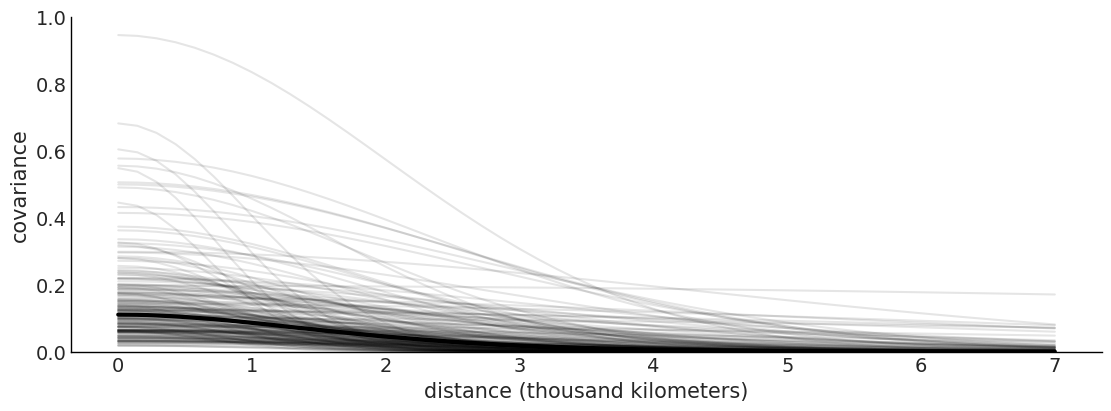

In [104]:
posterior_islands = cmdstanpy_data.posterior.stack(samples=("chain", "draw"))
trace_η = posterior_islands['eta'].values
trace_ℓ = posterior_islands['lengthscale_f'].values

_, ax = plt.subplots(1, 1, figsize=(11, 4))
xrange = np.linspace(0, 7)

median_ = np.median(trace_η[:,None] * (np.exp(-xrange**2 / (2*trace_ℓ[:,None]**2))), axis=0)

ax.plot(xrange, median_, lw=3)


ax.plot(xrange, (trace_η[::20][:, None] * np.exp(-xrange**2 / (2*trace_ℓ[::20][:, None]**2))).T,
        'C0', alpha=.1)

ax.set_ylim(0, 1)
ax.set_xlabel('distance (thousand kilometers)')
ax.set_ylabel('covariance')

In [108]:
# compute posterior median covariance among societies
Σ = np.median(trace_η) * (np.exp(-(islands_dist)**2 / (2*np.median(trace_ℓ)**2)))


# convert to correlation matrix
Σ_post = np.diag(np.diag(Σ)**-0.5)
ρ = Σ_post @  Σ @ Σ_post
ρ = pd.DataFrame(ρ, index=culture_labels, columns=culture_labels)

[Text(0, 0, 'Malekula'),
 Text(0, 1, 'Tikopia'),
 Text(0, 2, 'Santa Cruz'),
 Text(0, 3, 'Yap'),
 Text(0, 4, 'Lau Fiji'),
 Text(0, 5, 'Trobriand'),
 Text(0, 6, 'Chuuk'),
 Text(0, 7, 'Manus'),
 Text(0, 8, 'Tonga'),
 Text(0, 9, 'Hawaii')]

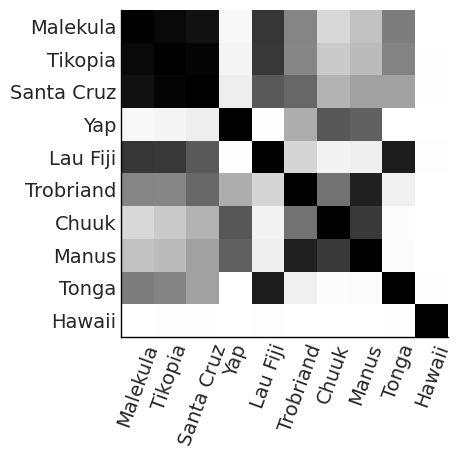

In [109]:
fig, ax = plt.subplots(figsize=(4.5, 4.5))
ax.imshow(ρ, cmap='gray_r')

ticks_loc = np.arange(10)
ax.set_xticks(ticks_loc)
ax.set_yticks(ticks_loc)
ax.set_xticklabels(culture_labels, rotation=70)
ax.set_yticklabels(culture_labels)